# PUMA Genealogy Improves Functional Representation via Topic Modeling

<img src="../figures/experiment_go_flow.svg" alt="PUMA Genealogy Improves Functional Representation via Topic Modeling" width="1500">

The workflow for the topic modeling experiment. The process begins with a Protein-GO Dataset derived from UniRef50 Human Proteins and Generic GO-Slim Annotations. This dataset is processed through three parallel pipelines: ESM-2-Based Representation generation: The ESM-2 model generates Protein Embeddings, which are then averaged by GO terms to create the ESM-2 GO Vectors. Standard Topic Model: Applies a standard c-TF-IDF calculation to data processed via PUMA \& Baseline methods to produce Standard GO Vectors. Graph-Aware Topic Model: Incorporates a Unit Similarity Graph to first smooth the document-term matrix before applying c-TF-IDF, resulting in Graph-Aware GO Vectors. Finally, in the validation step, we calculated the pairwise cosine similarities within the Standard and Graph-Aware models and evaluated their correlation with the ESM-2 vectors similarity structure using Spearman's Rank Correlation. The Representation panel visualizes the output of the Topic Model, displaying the network of PUMA units associated with specific Gene Ontology terms. It highlights that functionally related terms, such as transferase activity (GO:0016740) and catalytic activity, acting on a protein (GO:0140096), share similar PUMA units (e.g., EGACV), whereas unrelated terms, like DNA binding (GO:0003677), map to distinct units.

---

To assess the biological utility, we examined whether the distribution of PUMA units aligns with known functional annotations. We employed supervised topic modeling, where proteins are conceptualized as documents, PUMA units as words, and Gene Ontology (GO) terms serve as topics. Using the UniRef50 human dataset and experimentally validated generic GO-slim subset annotations sourced from QuickGO, we constructed functional representations for GO terms based on their constituent PUMA units.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_HOME"] = "/cta/share/users/esm"

In [ ]:
from time import time
import sqlite3
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import random
import pickle
import requests
import networkx as nx
import torch
from goatools.obo_parser import GODag
from goatools.gosubdag.gosubdag import GoSubDag
from goatools.mapslim import mapslim

from vocabulary_functions import load_tokenizers, vocabulary_lineage_builder
from experiment_go_functions import (
    get_esm2_model_and_tokenizer, get_esm2_embeddings_and_logits_batch, go_esm_vs_unit_similarity, split_go_evidence, scale_matrix,
    create_unit_documents, create_go_labels, create_bertopic_model, create_graph_aware_bertopic_model
)

/cta/users/bsuyunu/github/evolutionary-subword-tokenization/.venv/lib/python3.12/site-packages/goatools/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Gene Ontology (GO) and GO-Slim Setup

Here, we initialize the Gene Ontology Directed Acyclic Graph (DAG) and the generic GO-Slim subset. This structure allows us to map specific GO terms to broader functional categories, ensuring that our topic modeling targets high-level biological concepts (Molecular Function, Biological Process, Cellular Component) rather than overly specific terms.

We fetch the latest OBO files from the OBO library if they are not already present locally.

In [3]:
# --- GO DAG and GO Slim Setup ---
obo_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_path = "go-basic.obo"
if not os.path.exists(obo_path):
    with open(obo_path, "w") as f:
        f.write(requests.get(obo_url).text)
go_dag = GODag(obo_path)

goslim_url = "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"
goslim_path = "goslim_generic.obo"
if not os.path.exists(goslim_path):
    with open(goslim_path, "w") as f:
        f.write(requests.get(goslim_url).text)
goslim_dag = GODag(goslim_path)
goslim_terms = set(goslim_dag.keys())
go_subdag_slim = GoSubDag(goslim_terms, go_dag)

goslim_id2name = {}
goslim_name2id = {}
for k, v in goslim_dag.items():
    goslim_id2name[v.id] = v.name
    goslim_name2id[v.name] = v.id

go_id2name = {}
go_name2id = {}
for k, v in go_dag.items():
    go_id2name[v.id] = v.name
    go_name2id[v.name] = v.id

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
goslim_generic.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_generic.owl) 206 Terms
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


## Building the GO Hierarchy Graph



We construct a NetworkX DiGraph representing the relationships between GO terms within the GO-Slim subset. This graph explicitly links parent and child terms and roots them in the three main aspects of Gene Ontology: biological_process, cellular_component, and molecular_function.

In [4]:
G = nx.DiGraph()
for go_id, go_term in go_subdag_slim.go2obj.items():
    G.add_node(go_id, name=go_term.name, namespace=go_term.namespace)
    for parent in go_term.parents:
        if parent.id in go_subdag_slim.go2obj:  # Only connect if parent is also in slim
            G.add_edge(parent.id, go_id)
G.add_node('GO:0000000', name='root_node', namespace='root_node')
G.add_edge('GO:0000000', 'GO:0008150') # biological_process
G.add_edge('GO:0000000', 'GO:0005575') # cellular_component
G.add_edge('GO:0000000', 'GO:0003674') # molecular_function

## Tokenizer Configuration



We define the experimental parameters for PUMA tokenization. This includes the substitution matrices (BLOSUM62, PAM70), mutation cut-offs (e.g., 0.7), and vocabulary sizes. These configurations determine how the "protein units" (our words) are generated and how the genealogical relationships (mutational families) are defined.



Note that we are comparing PUMA against baselines across different vocabulary sizes (e.g., 12,800 and 51,200).

In [5]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.005, 0.05, 0.1, 0.2}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

vocab_sizes = [12800, 51200]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    }
]

# tokenizer_opts_list = []

# vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600, 51200]
# uniref_id = "50"

# for subs_matrix in ['blosum45', 'blosum62', 'pam70', 'pam250']:
#     for mutation_cutoff in [0.7, 0.8, 0.9]:
#         for min_mutation_freq in [0, 0.005, 0.05, 0.1, 0.2]:
#             if subs_matrix == 'pam250' and mutation_cutoff == 0.7:
#                 continue
#             tokenizer_opts_list.append(
#                 {
#                     'is_mut': True,
#                     'dataset': f'uniref{uniref_id}',
#                     'is_pretokenizer': False,
#                     'subs_matrix': subs_matrix,
#                     'mutation_cutoff': mutation_cutoff,
#                     'min_mutation_freq': min_mutation_freq,
#                     'min_mutation_len': 3,
#                     'max_mutation_len': 12,
#                     'vocab_size': vocab_sizes
#                 }
#             )

In [6]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {m: m.replace('blosum', 'BLOSUM').replace('pam', 'PAM') for m in methods}
methods2names = {k: f"{v.split()[0]}({', '.join(v.split()[1:])})" if 'PUMA' in v else v for k, v in methods2names.items()} 

vocab_lineage_list = vocabulary_lineage_builder(inner_vocab_list)

Building Vocabulary Lineage: 100%|██████████| 4/4 [00:00<00:00, 33.74it/s]


## Data Loading and Preprocessing



We load the protein sequences from the UniRef50 human database and their corresponding annotations from QuickGO. 



**Key filtering steps:**

1.  **Sequence Length:** We filter out sequences longer than 1000 amino acids.

2.  **Evidence Codes:** We strictly use experimentally validated annotations (EXP, IDA, IPI, IMP, IGI, IEP) to ensure high-quality ground truth, excluding computational predictions.

3.  **GO-Slim Mapping:** We map specific GO IDs to their corresponding GO-Slim terms using `mapslim`.

4.  **Frequency Filtering:** We drop GO terms associated with fewer than 50 proteins to ensure sufficient data for topic modeling.

5.  **Redundancy Removal:** We remove GO terms that are parents of other terms present in the dataset to avoid hierarchical redundancy.

In [7]:
# --- Database Connection and Data Loading ---
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"SELECT Entry as uniprot_id, Sequence as sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 1000].reset_index(drop=True)
df_protein = df_protein[df_protein['sequence'].str.len() > 0].reset_index(drop=True)

df_quickgo = pd.read_sql(f"SELECT uniprot_id, go_id, go_evidence FROM uniprot_quickgo_annotations", conn)
df_quickgo = df_quickgo[df_quickgo['uniprot_id'].isin(df_protein['uniprot_id'])]

# Filter by evidence code
go_evidence_experimental = ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']
# go_evidence_computational = ['ISS', 'ISO', 'ISA', 'ISM', 'IGC', 'RCA', 'TAS']# + ['IEA']
go_evidence_computational = []
df_quickgo = df_quickgo[df_quickgo['go_evidence'].isin(go_evidence_experimental + go_evidence_computational)].reset_index(drop=True)

df = df_quickgo.copy()

# Convert go_ids to go_slim_ids
df_quickgo['go_slim_id'] = df_quickgo['go_id'].apply(lambda x: list(mapslim(x, go_dag, goslim_dag)[0]) if x in go_dag else [])
df_quickgo = df_quickgo.explode(['go_slim_id']).dropna().reset_index(drop=True)

# Drop duplicates
df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).agg({'go_id': 'count', 'go_evidence': list}).reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.drop(columns=['go_id']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)

# Drop infrequent go terms
df_quickgo = df_quickgo[df_quickgo['go_id'].isin(df_quickgo['go_id'].value_counts()[df_quickgo['go_id'].value_counts() >= 50].index)].reset_index(drop=True)

df_quickgo = df_quickgo[df_quickgo['go_id'].isin(go_dag)]

go_ids = df_quickgo['go_id'].unique()
df_quickgo = df_quickgo[~df_quickgo['go_id'].isin({go_id for go_id in go_ids for child in goslim_dag[go_id].get_all_children() if child in go_ids})].reset_index(drop=True)

# Add GO term information
df_quickgo['go_name'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].name)
df_quickgo['go_aspect'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].namespace)

conn.close()

df_quickgo

,uniprot_id,go_id,go_evidence,go_name,go_aspect
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component
3,X6RH80,GO:0005654,[IDA],nucleoplasm,cellular_component
4,X6RAE7,GO:0005794,[IDA],Golgi apparatus,cellular_component
...,...,...,...,...,...
20900,A0A024RBG1,GO:0005829,[IDA],cytosol,cellular_component
20901,A0A024R7P0,GO:0005654,[IDA],nucleoplasm,cellular_component
20902,A0A024R7P0,GO:0005829,[IDA],cytosol,cellular_component
20903,A0A024R531,GO:0005654,[IDA],nucleoplasm,cellular_component


In [8]:
df_quickgo['go_aspect'].value_counts()

go_aspect
cellular_component    10520
biological_process     6220
molecular_function     4165
Name: count, dtype: int64

In [9]:
df_quickgo['go_name'].value_counts()

go_name
nucleoplasm                                  3458
cytosol                                      2641
regulation of DNA-templated transcription     996
plasma membrane                               940
DNA binding                                   697
                                             ... 
ATP-dependent activity                         56
sulfur compound metabolic process              55
protein localization to plasma membrane        54
DNA recombination                              54
molecular sequestering activity                50
Name: count, Length: 67, dtype: int64

## Sequence Tokenization



The protein sequences are tokenized using the loaded PUMA tokenizers. Additionally, 3-mer and 4-mer tokenizations are generated as baselines. The tokenized sequences are merged with the GO annotation data to form the final `df_protein_go` dataframe.

In [ ]:
# --- Tokenization and Data Merging ---
for name, tokenizer in tqdm(tokenizer_list.items(), desc="Tokenizing Sequences"):
    df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]
df_protein_go = pd.merge(df_quickgo, df_protein, how='inner', on='uniprot_id')

df_protein_go['3mer'] = df_protein_go['sequence'].apply(lambda seq: [seq[i:i+3] for i in range(0,len(seq),3)])
df_protein_go['4mer'] = df_protein_go['sequence'].apply(lambda seq: [seq[i:i+4] for i in range(0,len(seq),4)])

df_protein_go.head()

Tokenizing Sequences: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


,uniprot_id,go_id,go_evidence,go_name,go_aspect,sequence,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 51200,PUMA pam70 0.7 0.05 12800,PUMA pam70 0.7 0.05 51200,3mer,4mer
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ERWV, YG, PGG, A...","[MAGL, TDL, QRL, QARV, EEL, ER, WV, YG, PGG, A...","[MAGL, TDL, QRL, QARV, EELER, WV, YG, PGG, ARG...","[MAG, LTD, LQR, LQA, RVE, ELE, RWV, YGP, GGA, ...","[MAGL, TDLQ, RLQA, RVEE, LERW, VYGP, GGAR, GSR..."
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ERWV, YG, PGG, A...","[MAGL, TDL, QRL, QARV, EEL, ER, WV, YG, PGG, A...","[MAGL, TDL, QRL, QARV, EELER, WV, YG, PGG, ARG...","[MAG, LTD, LQR, LQA, RVE, ELE, RWV, YGP, GGA, ...","[MAGL, TDLQ, RLQA, RVEE, LERW, VYGP, GGAR, GSR..."
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,"[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SN, W...","[EVK, GLF, KSE, NCP, KVI, SCE, FAH, NSN, WYI, ...","[EVKG, LFKS, ENCP, KVIS, CEFA, HNSN, WYIT, FQS..."
3,X6RH80,GO:0005654,[IDA],nucleoplasm,cellular_component,MEKRTCALCPKDVEYNVLYFAQSENIAAHENCLLYSSGLVECEDQD...,"[MEK, RT, CAL, C, PK, DV, EY, NVL, Y, FA, Q, S...","[MEK, RT, CAL, C, PKDV, EY, NVL, YFA, Q, SENI,...","[MEK, RT, CAL, C, PK, DV, EY, NVL, Y, FAQ, SEN...","[MEK, RT, CAL, CPK, DV, EY, NVL, Y, FAQ, SENI,...","[MEK, RTC, ALC, PKD, VEY, NVL, YFA, QSE, NIA, ...","[MEKR, TCAL, CPKD, VEYN, VLYF, AQSE, NIAA, HEN..."
4,X6RAE7,GO:0005794,[IDA],Golgi apparatus,cellular_component,XQPSPEPHSPTEPPAWGSSIVKVPSGIFDVNSRKSSTGSISNVLFS...,"[X, QPSP, EPH, SPT, EPP, A, WG, SSIV, KV, PSGI...","[X, QPSP, EPH, SPT, EPPA, WG, SSIV, KV, PSGI, ...","[X, Q, PSP, EPH, SP, TE, PPA, WG, SSIV, KV, PS...","[X, QPSP, EPH, SPTE, PPA, WG, SSIV, KV, PSG, I...","[XQP, SPE, PHS, PTE, PPA, WGS, SIV, KVP, SGI, ...","[XQPS, PEPH, SPTE, PPAW, GSSI, VKVP, SGIF, DVN..."


## ESM-2 Embedding Generation



We generate protein embeddings using the ESM-2 650M model (`esm2_t33_650M_UR50D`), which serves as a high-fidelity functional representation baseline.



We generate embeddings by averaging the final hidden layer of ESM-2 for each sequence. These embeddings are then stored in a dictionary mapping UniProt IDs to their vector representations.

In [ ]:
# model, tokenizer, device = get_esm2_model_and_tokenizer()
model, tokenizer, device = get_esm2_model_and_tokenizer(model_name="facebook/esm2_t36_3B_UR50D")

unique_sequences = list(set(df_protein_go['sequence']))
sequence_data_temp = get_esm2_embeddings_and_logits_batch(unique_sequences, model, tokenizer, device, batch_size=64, max_length=1024, extract_layers=None)

sequence_data = dict()
for k, v in tqdm(sequence_data_temp.items()):
    sequence_data[df_protein_go[(df_protein_go['sequence'] == k)].iloc[0]['uniprot_id']] = v['embeddings'][-1].mean(axis=0)

del sequence_data_temp

torch.cuda.empty_cache() if torch.cuda.is_available() else None


## Creating Target GO Vectors (ESM-2)



To create a target representation for each GO term, we average the ESM-2 embeddings of all proteins annotated with that specific term. This results in `df_go_to_uniprot`, which contains the aggregated ESM-2 vector for every GO ID.

In [ ]:
df_go_to_uniprot = df_protein_go.groupby('go_id').agg({'uniprot_id': set}).reset_index()
df_go_to_uniprot['esm_embedding'] = df_go_to_uniprot.apply(lambda row: np.mean([sequence_data[uid] for uid in row['uniprot_id']], axis=0), axis=1)
df_go_to_uniprot = df_go_to_uniprot.set_index('go_id')


## Topic Modeling and Graph-Aware Smoothing



This section performs the core experiment:



1.  **Data Preparation:** We filter for a specific GO aspect (e.g., 'molecular_function') and balance the dataset by undersampling highly represented GO terms.

2.  **Standard Topic Model:** We apply standard BERTopic modeling using c-TF-IDF to generate GO vectors from PUMA units.

3.  **Graph-Aware Topic Model:** We incorporate PUMA's genealogical structure. We build a weighted adjacency matrix $A$ where edges represent hierarchical and mutational relationships ($\alpha, \beta, \theta$). We then smooth the document-term matrix using $((1-\lambda)I + \lambda A)$ before calculating c-TF-IDF.



Finally, we compare the Spearman correlation of the unit-similarity matrix against the ESM-similarity matrix for both the Standard and Graph-Aware models.

In [ ]:
# ['cellular_component', 'molecular_function', 'biological_process']
go_aspect = 'molecular_function'

df_train = df_protein_go[df_protein_go['go_aspect'] == go_aspect].reset_index(drop=True).copy()
df_train, _ = split_go_evidence(df_train, None, split_ratio=0, denom=1, random_state=42)
df_train = df_train[df_train['go_id'].isin(df_train['go_id'].value_counts()[df_train['go_id'].value_counts() >= 100].index)].reset_index(drop=True).copy()

tokenizer_col = list(tokenizer_list.keys())[1]
print(tokenizer_col)
go_col = 'go_name'
token_len_thr = 1
top_n_words = 50
max_df = 0.9
min_df = 1
lambda_smooth = .5
alpha = 1
beta = 3
theta = 2

documents = create_unit_documents(df_train, tokenizer_col, token_len_thr)
go_labels = create_go_labels(df_train, go_col)

topic_model, _ = create_bertopic_model(documents, go_labels, token_len_thr, top_n_words, max_df, min_df)

print('Standard:', go_esm_vs_unit_similarity(topic_model, df_go_to_uniprot, go_name2id, 'all')['correlation_spearman_esm_unit'])

if tokenizer_col not in ['3mer', '4mer']:
    unit_relationships = {'hierarchical': {}, 'mutational': {}}
    for unit, lineage in vocab_lineage_list[tokenizer_col].items():
        if len(lineage['child_pair']) > 0:
            unit_relationships['hierarchical'][unit] = lineage['child_pair']
        if len(lineage['child_mutation']) > 0:
            unit_relationships['mutational'][unit] = lineage['child_mutation']
    topic_model_ga, _, similarity_matrix = create_graph_aware_bertopic_model(documents, go_labels, unit_relationships, token_len_thr, top_n_words, max_df, min_df, lambda_smooth, alpha, beta, theta, False)
    print('Graph-aware:', go_esm_vs_unit_similarity(topic_model_ga, df_go_to_uniprot, go_name2id, 'all')['correlation_spearman_esm_unit'])

PUMA blosum62 0.7 0.05 51200
Standard: 0.5157081724245904
Graph-aware: 0.6834150923703164



## Visualizing Similarity Matrices



We visualize the pairwise similarity matrices using heatmaps. This allows us to visually compare:

1.  **PUMA Unit Similarity (Standard Model)**

2.  **ESM Embedding Similarity (Target)**

3.  **PUMA Unit Similarity (Graph-Aware Model)**



A higher resemblance to the ESM matrix indicates a better functional representation.

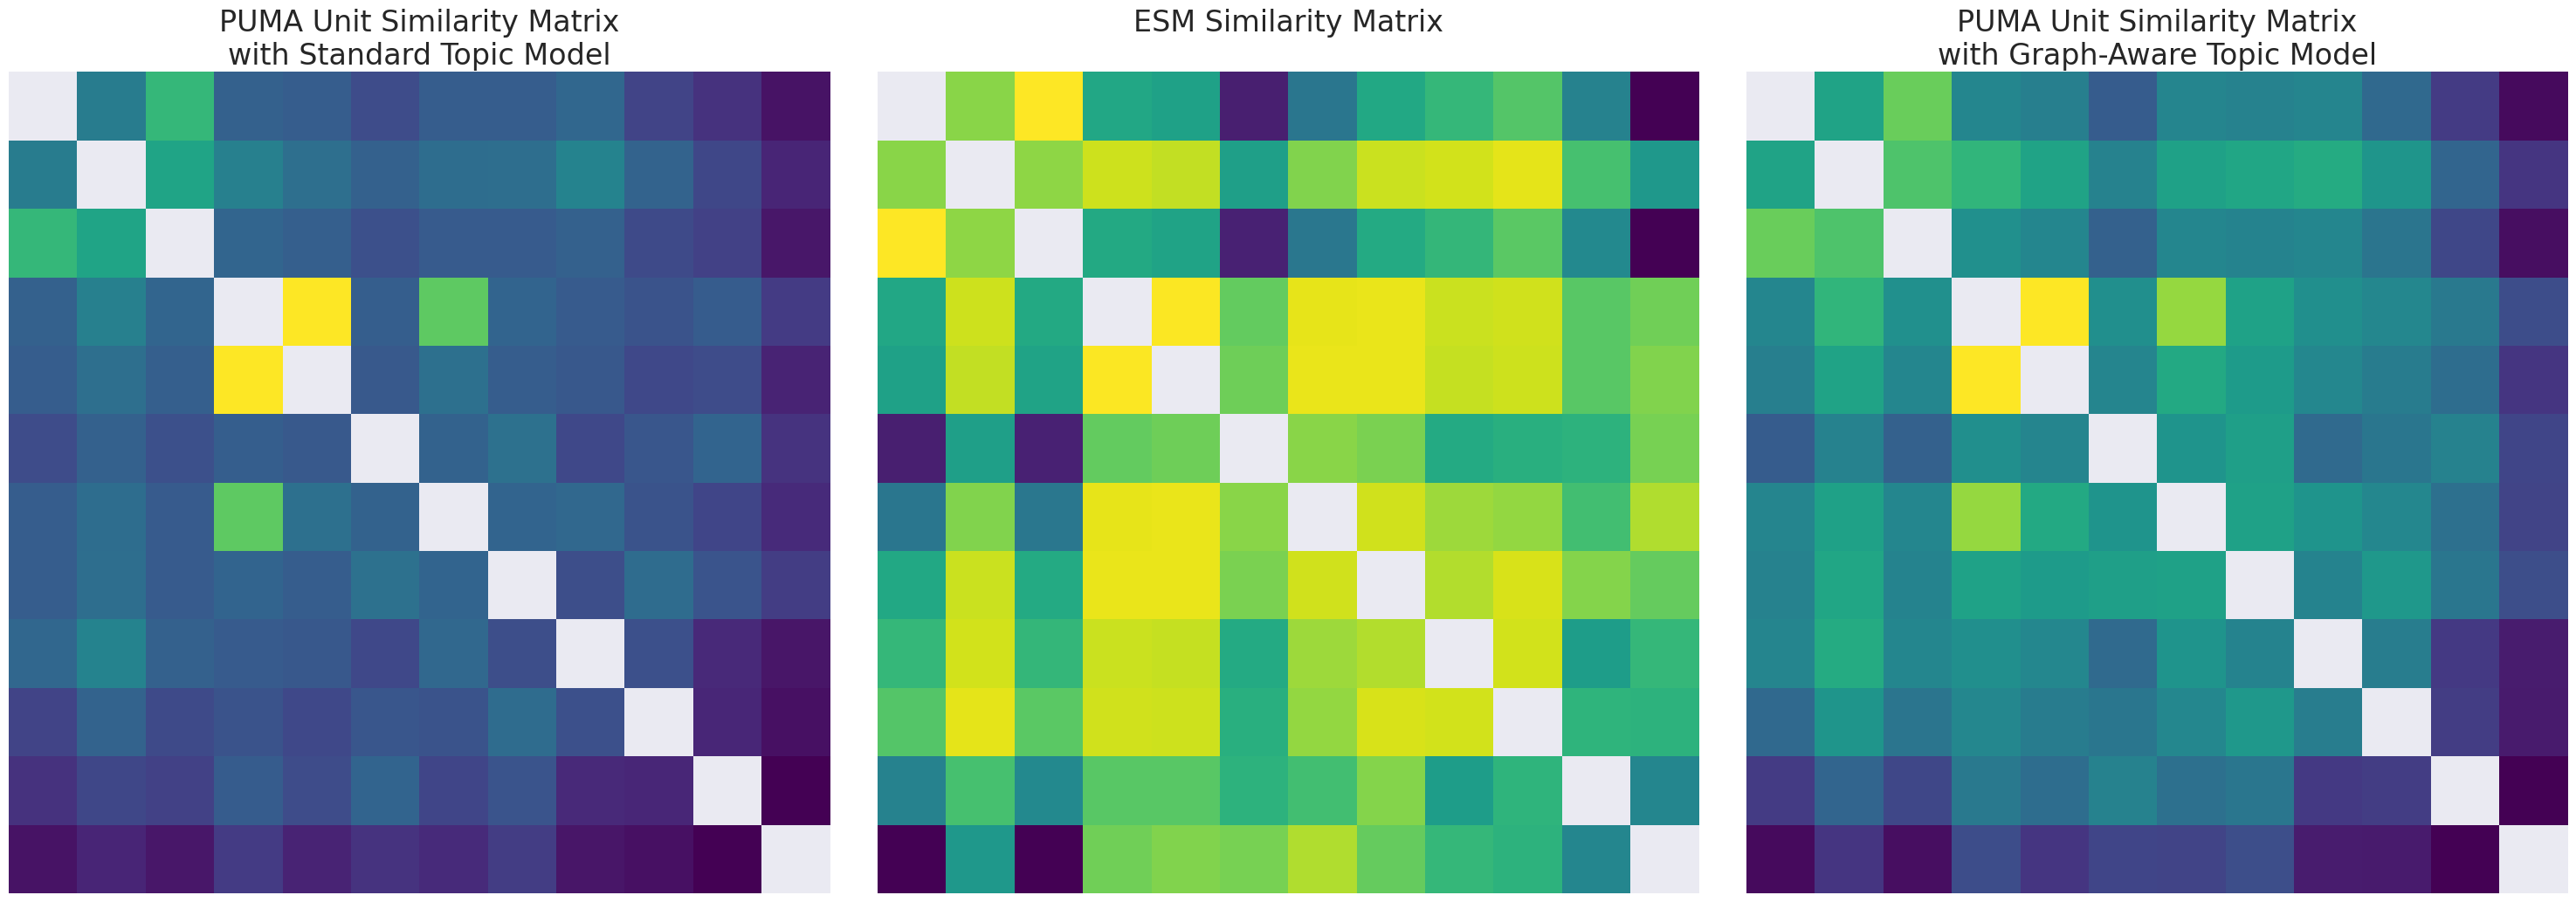

In [62]:
sns.set_style('dark')

unit_similarity_matrix, esm_similarity_matrix = go_esm_vs_unit_similarity(topic_model, df_go_to_uniprot, go_name2id, return_sims=True)
unit_similarity_matrix_ga, esm_similarity_matrix = go_esm_vs_unit_similarity(topic_model_ga, df_go_to_uniprot, go_name2id, return_sims=True)

esm_similarity_matrix_scaled = scale_matrix(esm_similarity_matrix)
unit_similarity_matrix_scaled = scale_matrix(unit_similarity_matrix)
unit_similarity_matrix_ga_scaled = scale_matrix(unit_similarity_matrix_ga)

n = esm_similarity_matrix_scaled.shape[0]

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

sns.heatmap(np.nan_to_num(unit_similarity_matrix_scaled.T)+np.nan_to_num(unit_similarity_matrix_scaled)+np.diag(np.ones(n)*np.nan), ax=axes[0], cmap='viridis', cbar=False, square=True, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
axes[0].set_title('PUMA Unit Similarity Matrix\nwith Standard Topic Model', fontsize=24)

sns.heatmap(np.nan_to_num(esm_similarity_matrix_scaled.T)+np.nan_to_num(esm_similarity_matrix_scaled)+np.diag(np.ones(n)*np.nan), ax=axes[1], cmap='viridis', cbar=False, square=True, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
axes[1].set_title('ESM Similarity Matrix\n', fontsize=24)

sns.heatmap(np.nan_to_num(unit_similarity_matrix_ga_scaled.T)+np.nan_to_num(unit_similarity_matrix_ga_scaled)+np.diag(np.ones(n)*np.nan), ax=axes[2], cmap='viridis', cbar=False, square=True, vmin=0, vmax=1, xticklabels=False, yticklabels=False)
axes[2].set_title('PUMA Unit Similarity Matrix\nwith Graph-Aware Topic Model', fontsize=24)

plt.tight_layout()
plt.show()


## Side-by-Side Comparison



A focused comparison between the ESM similarity matrix and the Graph-Aware PUMA similarity matrix, including topic labels for detailed inspection of specific GO term relationships.

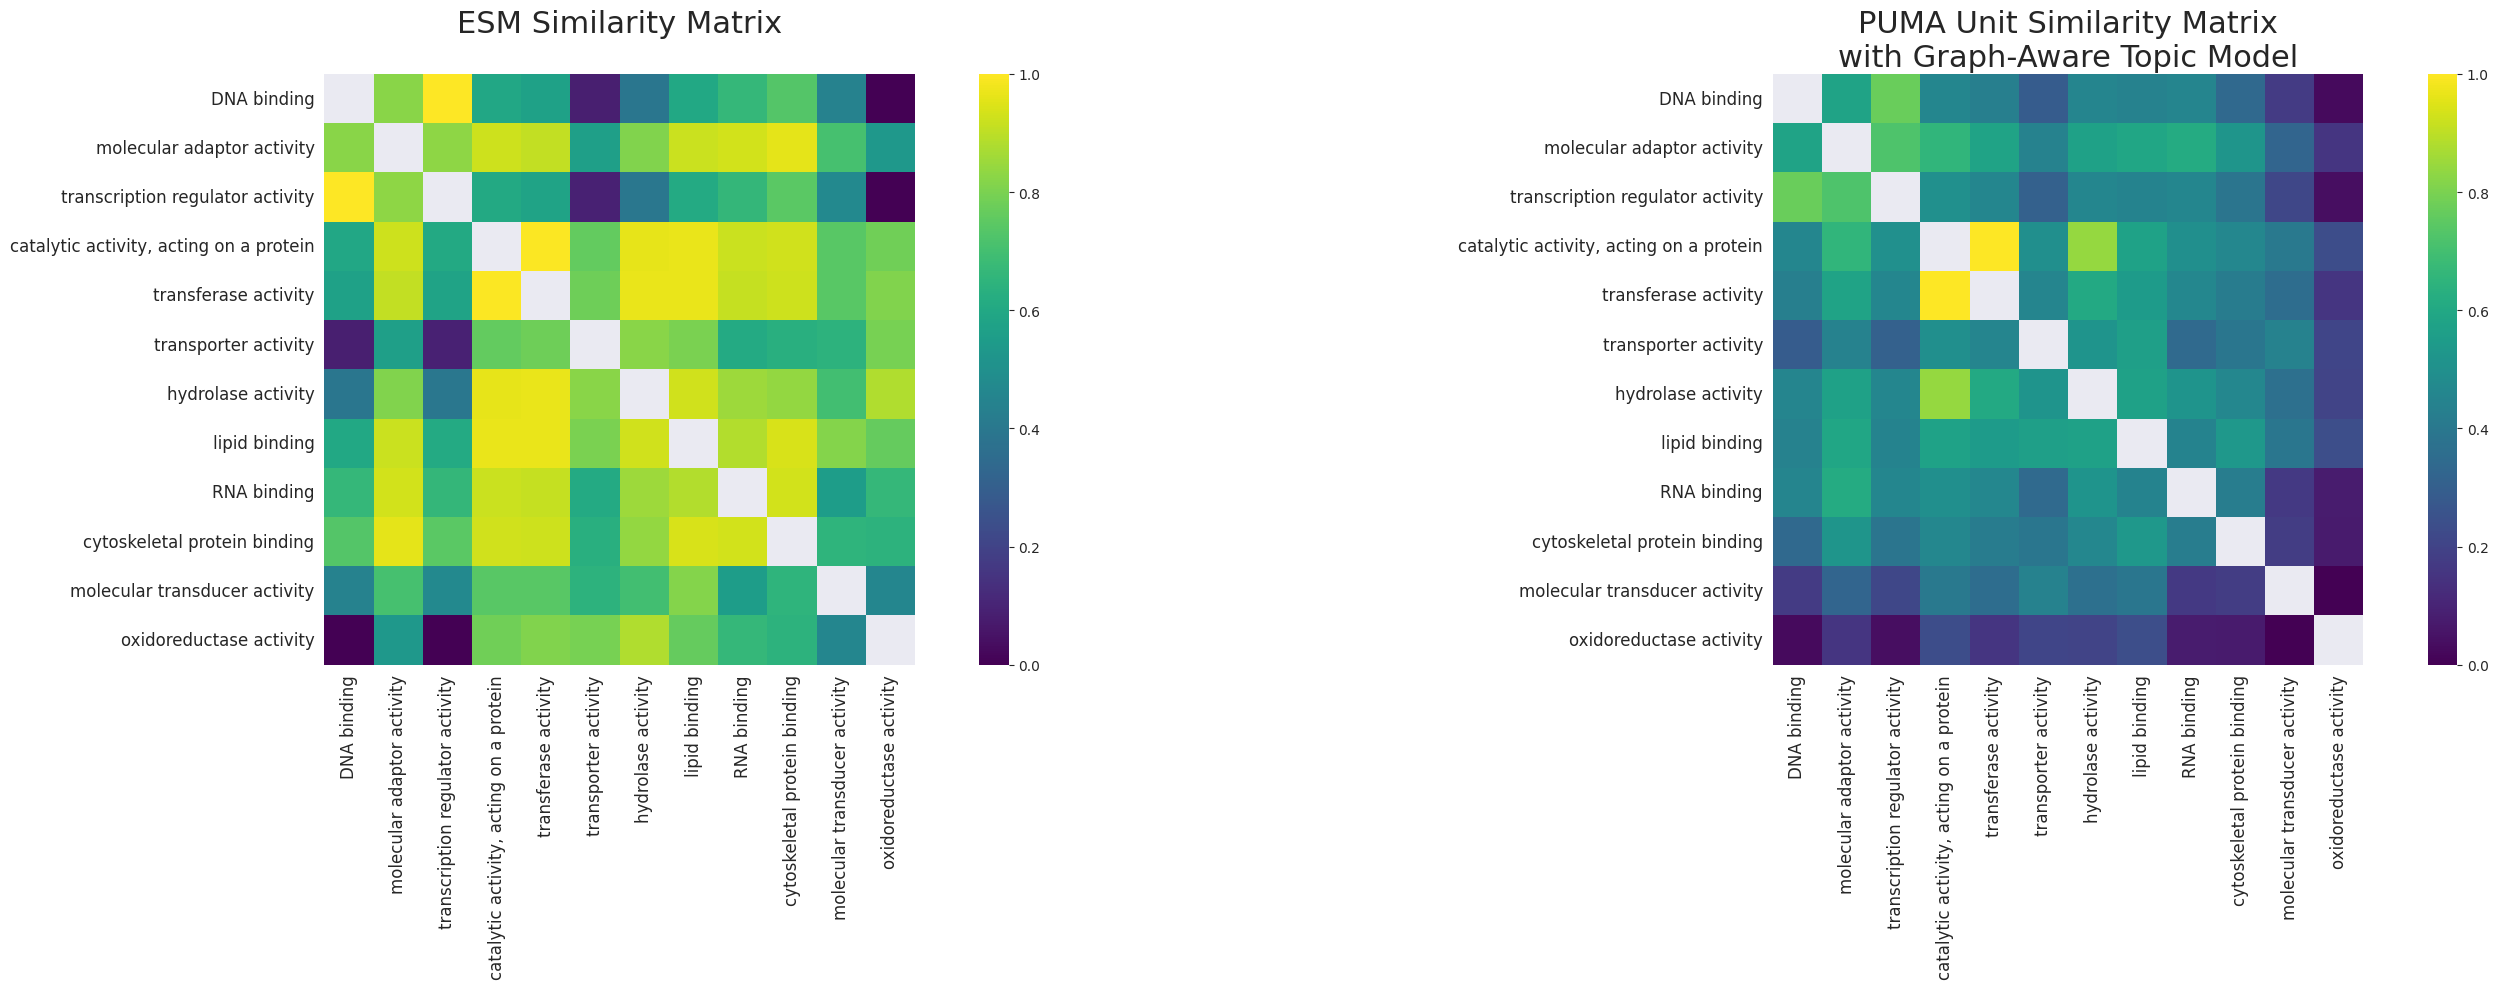

In [63]:
# Set up side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

# Heatmap for matrix A
sns.heatmap(np.nan_to_num(esm_similarity_matrix_scaled.T)+np.nan_to_num(esm_similarity_matrix_scaled)+np.diag(np.ones(n)*np.nan), ax=axes[0], cmap='viridis', cbar=True, square=True, vmin=0, vmax=1)
axes[0].set_title('ESM Similarity Matrix\n', fontsize=22)
axes[0].set_xticks(np.arange(len(topic_model.custom_labels_)) + 0.5)
axes[0].set_yticks(np.arange(len(topic_model.custom_labels_)) + 0.5)
axes[0].set_xticklabels(topic_model.custom_labels_, rotation=90, fontsize=12)
axes[0].set_yticklabels(topic_model.custom_labels_, rotation=0, fontsize=12)

# Heatmap for matrix B
sns.heatmap(np.nan_to_num(unit_similarity_matrix_ga_scaled.T)+np.nan_to_num(unit_similarity_matrix_ga_scaled)+np.diag(np.ones(n)*np.nan), ax=axes[1], cmap='viridis', cbar=True, square=True, vmin=0, vmax=1)
axes[1].set_title('PUMA Unit Similarity Matrix\nwith Graph-Aware Topic Model', fontsize=22)
axes[1].set_xticks(np.arange(len(topic_model.custom_labels_)) + 0.5)
axes[1].set_yticks(np.arange(len(topic_model.custom_labels_)) + 0.5)
axes[1].set_xticklabels(topic_model.custom_labels_, rotation=90, fontsize=12)
axes[1].set_yticklabels(topic_model.custom_labels_, rotation=0, fontsize=12)

plt.tight_layout()
plt.show()


## Performance Evaluation (Violin Plots)



We generate violin plots to statistically evaluate the Spearman correlations across different vocabulary sizes.



**Key Observations to Validate:**

1.  **Standard vs. Graph-Aware:** Does the graph-aware model (blue) consistently outperform the standard model (orange)?

2.  **Vocabulary Size:** How does performance change as the vocabulary size increases? (e.g., peaking at 6,400 or 12,800).

3.  **Baselines:** Comparison against k-mer (3mer, 4mer) and BPE baselines.

In [ ]:
results_df_raw = pd.read_csv('result_files/go_slim_analysis_unit_sim_mf.csv')
results_df_raw

,correlation_spearman_esm_unit,p_value_spearman_esm_unit,go_aspect,go_thr,train_data_split,denom,tokenizer_col,tokenizer,vocab_size,token_len_thr,...,max_df,min_df,top_n,top_n_strat,normal_random,epoch,lambda_smooth,alpha,beta,theta
0,0.213374,8.539485e-02,molecular_function,100,undersample,1,BPE 800,BPE,800,1,...,0.9,1,1,all,normal,0,0.5,1,3,2
1,0.237259,5.509033e-02,molecular_function,100,undersample,1,BPE 800,BPE,800,1,...,0.9,1,1,all,normal,0,0.5,1,3,2
2,0.586515,2.280492e-07,molecular_function,100,undersample,1,BPE 1600,BPE,1600,1,...,0.9,1,1,all,normal,0,0.5,1,3,2
3,0.563052,8.596275e-07,molecular_function,100,undersample,1,BPE 1600,BPE,1600,1,...,0.9,1,1,all,normal,0,0.5,1,3,2
4,0.688175,1.717685e-10,molecular_function,100,undersample,1,BPE 3200,BPE,3200,1,...,0.9,1,1,all,normal,0,0.5,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7865,0.544014,2.346112e-06,molecular_function,100,undersample,1,PUMA pam250 0.9 0.2 51200,PUMA pam250 0.9 0.2,51200,1,...,0.9,1,1,all,normal,9,0.5,1,3,2
7866,0.609268,5.676026e-08,molecular_function,100,undersample,1,PUMA pam250 0.9 0.2 51200,PUMA pam250 0.9 0.2,51200,1,...,0.9,1,1,all,normal,9,0.5,1,3,2
7867,0.530947,4.513463e-06,molecular_function,100,undersample,1,3mer,3mer,0,1,...,0.9,1,1,all,normal,9,0.5,1,3,2
7868,0.444484,1.848488e-04,molecular_function,100,undersample,1,4mer,4mer,0,1,...,0.9,1,1,all,normal,9,0.5,1,3,2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


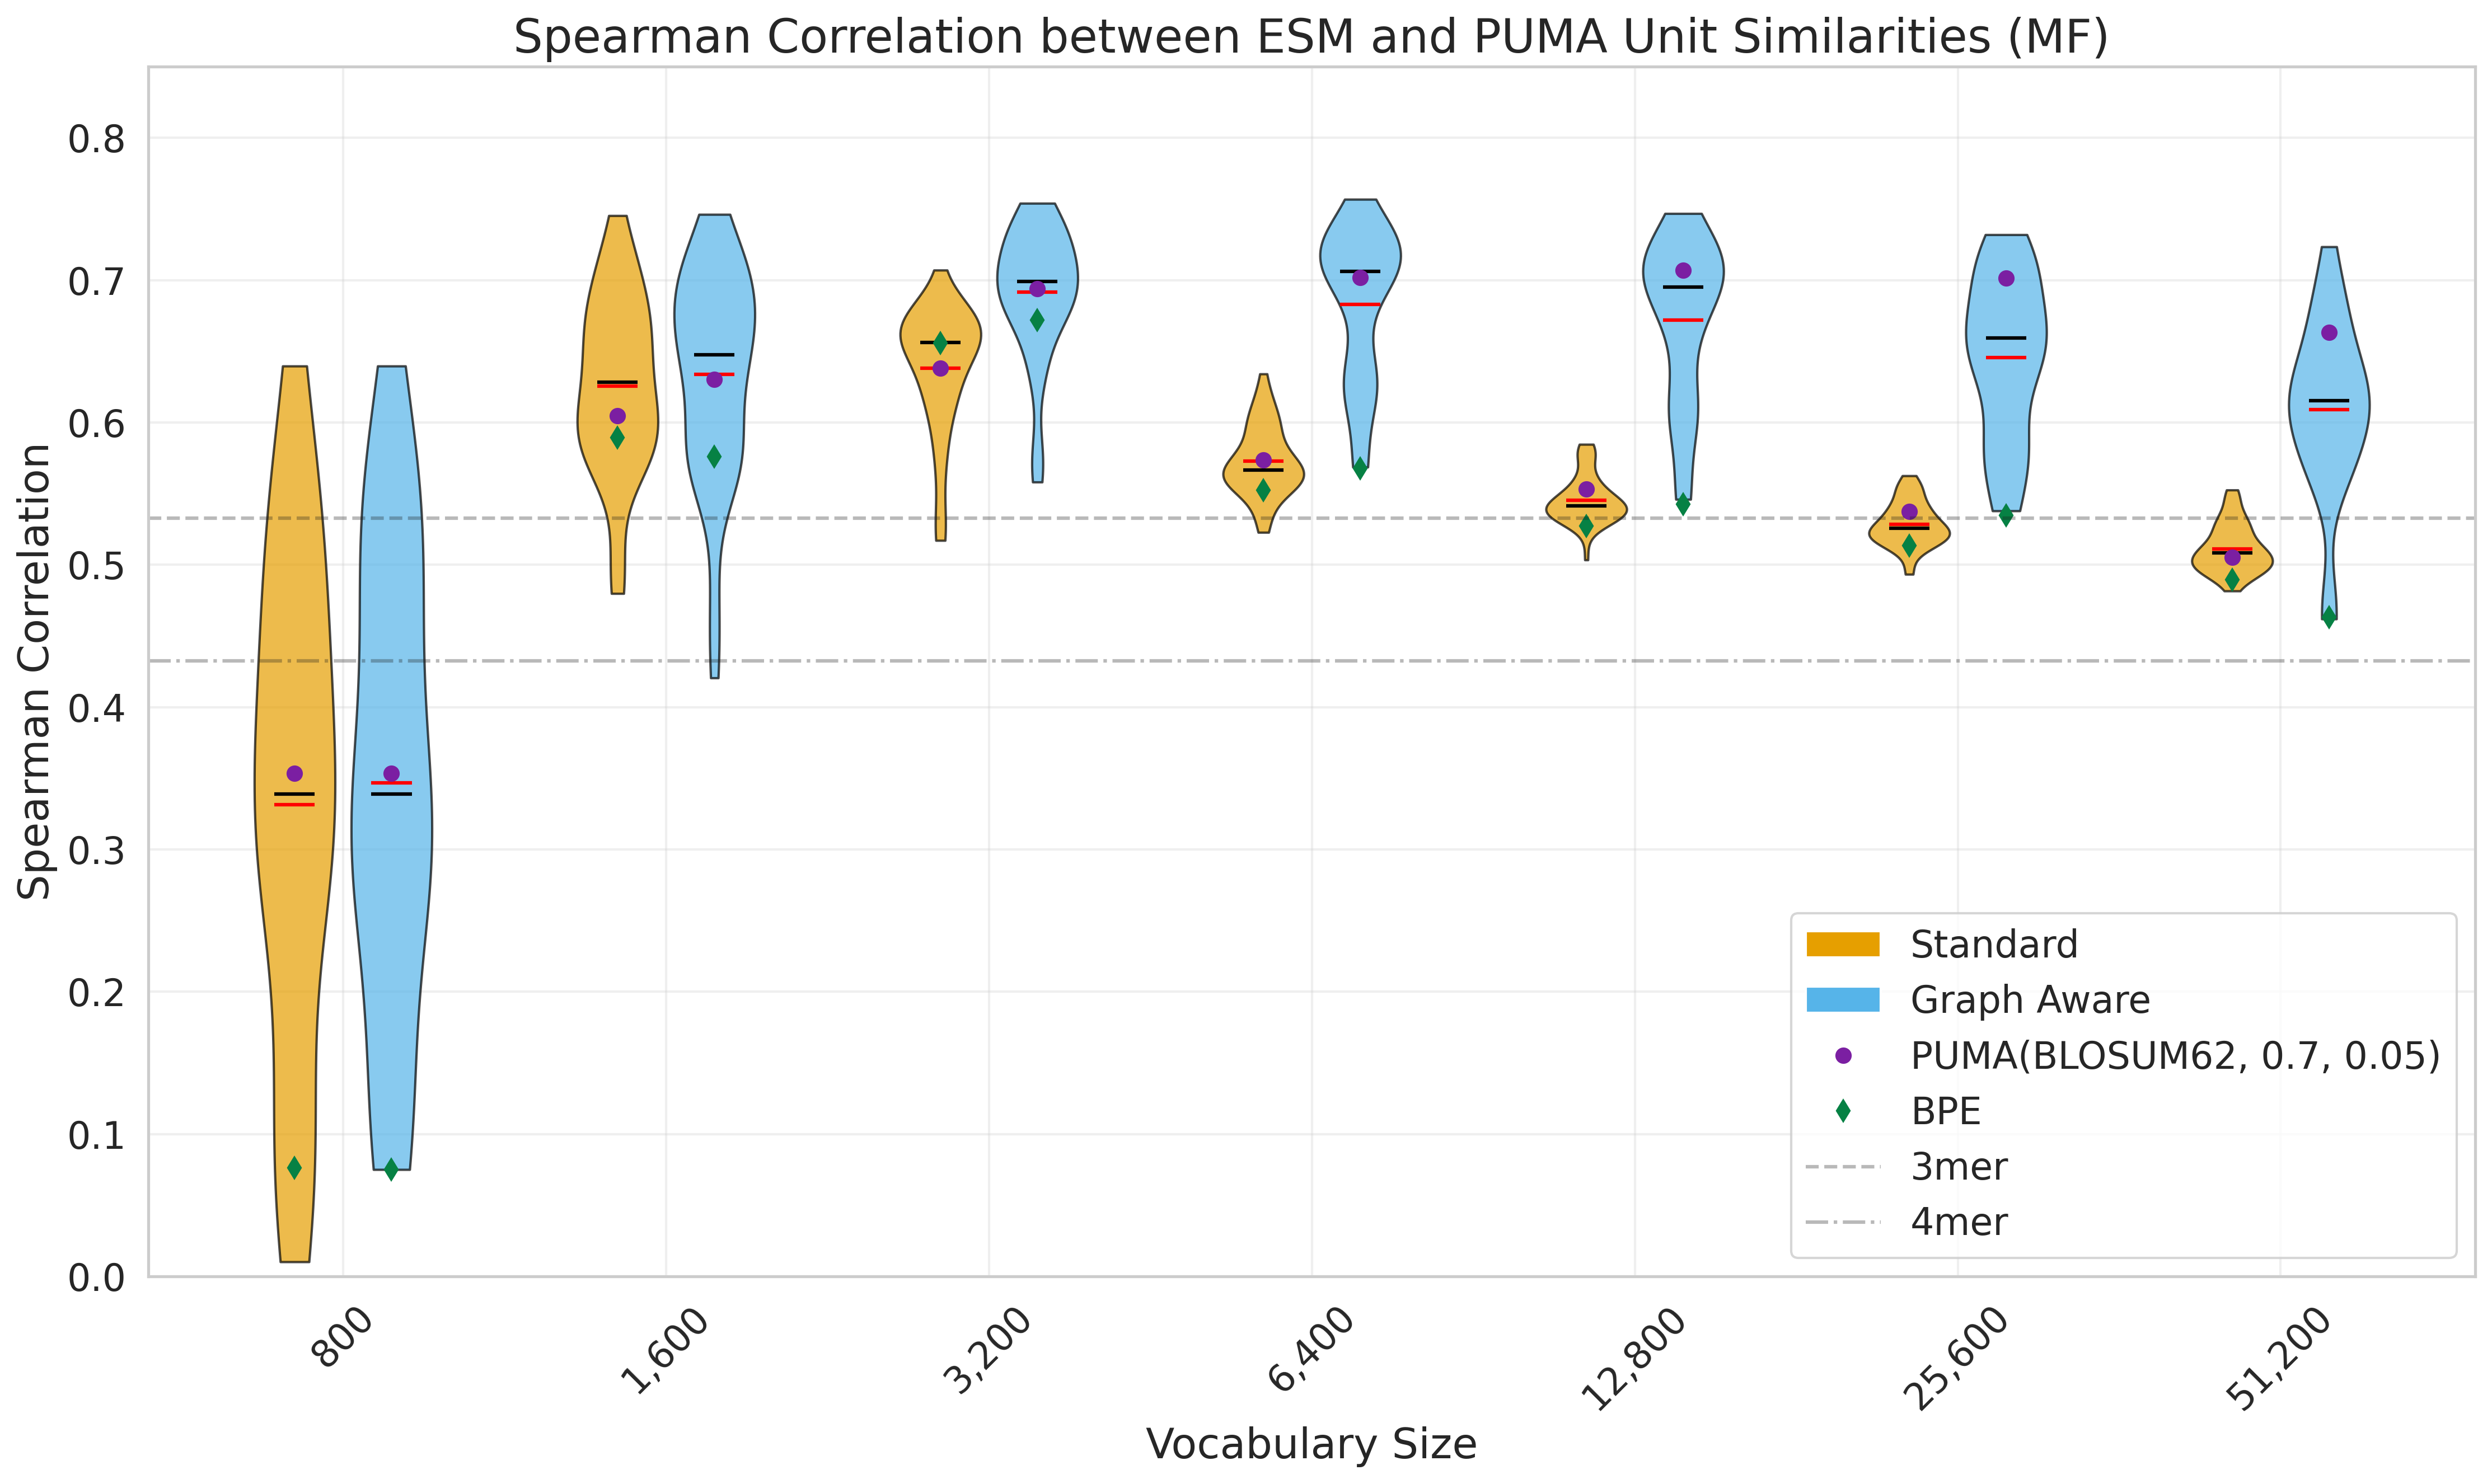

In [ ]:
sns.set_style("whitegrid")

# --- plot ---
fig, ax1 = plt.subplots(figsize=(15, 9))

colors = {
    "standard": "#E69F00",
    "graph_aware": "#56B4E9", 
} 
go_aspect = 'molecular_function' #['molecular_function', 'biological_process', 'cellular_component']

metric = 'correlation_spearman_esm_unit'
results_df = results_df_raw[results_df_raw['top_n_strat'] == 'all'].groupby(['go_aspect', 'topic_model', 'tokenizer', 'vocab_size']).agg({'correlation_spearman_esm_unit': 'mean'}).reset_index()

kmers = {}
kmers['3mer'] = {go_aspect: results_df[(results_df['tokenizer'] == '3mer') & (results_df['go_aspect'] == go_aspect)][metric].iloc[0]}
kmers['4mer'] = {go_aspect: results_df[(results_df['tokenizer'] == '4mer') & (results_df['go_aspect'] == go_aspect)][metric].iloc[0]}

results_df = results_df[results_df['vocab_size'] != 0]

offset = 0.3  # horizontal offset for separation
vocab_sizes = sorted(results_df["vocab_size"].unique())
topic_models = ['standard', 'graph_aware']
topicmodesl2label = {
    "standard": "Standard",
    "graph_aware": "Graph Aware"
}

goaspect2labe = {
    "molecular_function": "Molecular Function",
    "biological_process": "Biological Process",
    "cellular_component": "Cellular Component"
}

for i, topic_model in enumerate(topic_models):
    df_filtered = results_df[(results_df["topic_model"] == topic_model) & (results_df["go_aspect"] == go_aspect)]
    for j, ((v_size, ), final_group) in enumerate(df_filtered.groupby(["vocab_size"])):
        final_group = final_group[final_group['tokenizer'] != 'BPE']
        vals = final_group[metric].values

        # plot violin, shifted for visibility
        parts = ax1.violinplot(
            vals,
            # positions=[i],  # shift left/center/right
            positions=[j + (i - 0.5) * offset],
            widths=0.25,
            showmeans=True,
            showmedians=True,
            showextrema=False
        )
        # colorize
        for pc in parts['bodies']:
            pc.set_facecolor(colors[topic_model])
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color("black")
        if 'cmeans' in parts:
            parts['cmeans'].set_color("red")

# --- labels, legend, cosmetics ---
ax1.set_xticks(range(len(vocab_sizes)))
ax1.set_xticklabels([f"{v:,}" for v in vocab_sizes], rotation=45, ha="center")
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlabel("Vocabulary Size", fontsize=18)
ax1.set_ylabel("Spearman Correlation", fontsize=18)
ax1.set_ylim(bottom=-0, top=0.85)
# ax1.set_ylim(bottom=-0.25, top=0.65)
ax1.set_title(f"Spearman Correlation between ESM and PUMA Unit Similarities (MF)", fontsize=20)
ax1.grid(True, alpha=0.3)


legend_handles = [Patch(facecolor=colors[m], label=topicmodesl2label[m]) for m in topic_models]

method_colors = ["#7B1FA2", "#068144"]
method_markers = ["o", "d"]
for mx, method in enumerate(['PUMA blosum62 0.7 0.05', 'BPE']):
    method_df = results_df[results_df['tokenizer'] == method]
    for i, topic_model in enumerate(topic_models):
        df_filtered = method_df[(method_df["topic_model"] == topic_model) & (results_df["go_aspect"] == go_aspect)]
        positions = [j + (i - 0.5) * offset for j in range(len(vocab_sizes))]
        line_vals = [df_filtered[df_filtered['vocab_size'] == vocab_size][metric].mean() for vocab_size in vocab_sizes]
        (line_handle,) = ax1.plot(positions, line_vals, method_markers[mx], color=method_colors[mx], markersize=6, label=methods2names[method])
    legend_handles.append(line_handle)

kmer3_handle = ax1.axhline(y=kmers['3mer'][go_aspect], color='k', linestyle='--', linewidth=1.5, alpha=0.3, label='3mer')
kmer4_handle = ax1.axhline(y=kmers['4mer'][go_aspect], color='k', linestyle='-.', linewidth=1.5, alpha=0.3, label='4mer')
# kmer5_handle = ax1.axhline(y=kmers['5mer'][go_aspect], color='k', linestyle=':', linewidth=1.5, alpha=0.3, label='5mer')
legend_handles.append(kmer3_handle)
legend_handles.append(kmer4_handle)
# legend_handles.append(kmer5_handle)

ax1.legend(handles=legend_handles, loc='lower right', fontsize=16)

plt.tight_layout()
plt.rcParams['figure.dpi'] = 300
plt.savefig("figures/go_sim_all_mf.eps", bbox_inches='tight')
plt.savefig("figures/go_sim_all_mf.png", bbox_inches='tight')
plt.show()


## Alignment Cut-off Impact Analysis



This plot examines the impact of the alignment score cut-off ($a$) on functional representation. We plot the difference in Spearman correlation between models trained with a 0.7 cut-off and those with a 0.8 cut-off.



* **Positive values:** 0.7 cut-off performs better.

* **Negative values:** 0.8 cut-off performs better.



This helps validate the hypothesis that a looser cut-off (0.7) enables richer mutational relationships that improve representation as vocabulary size increases.

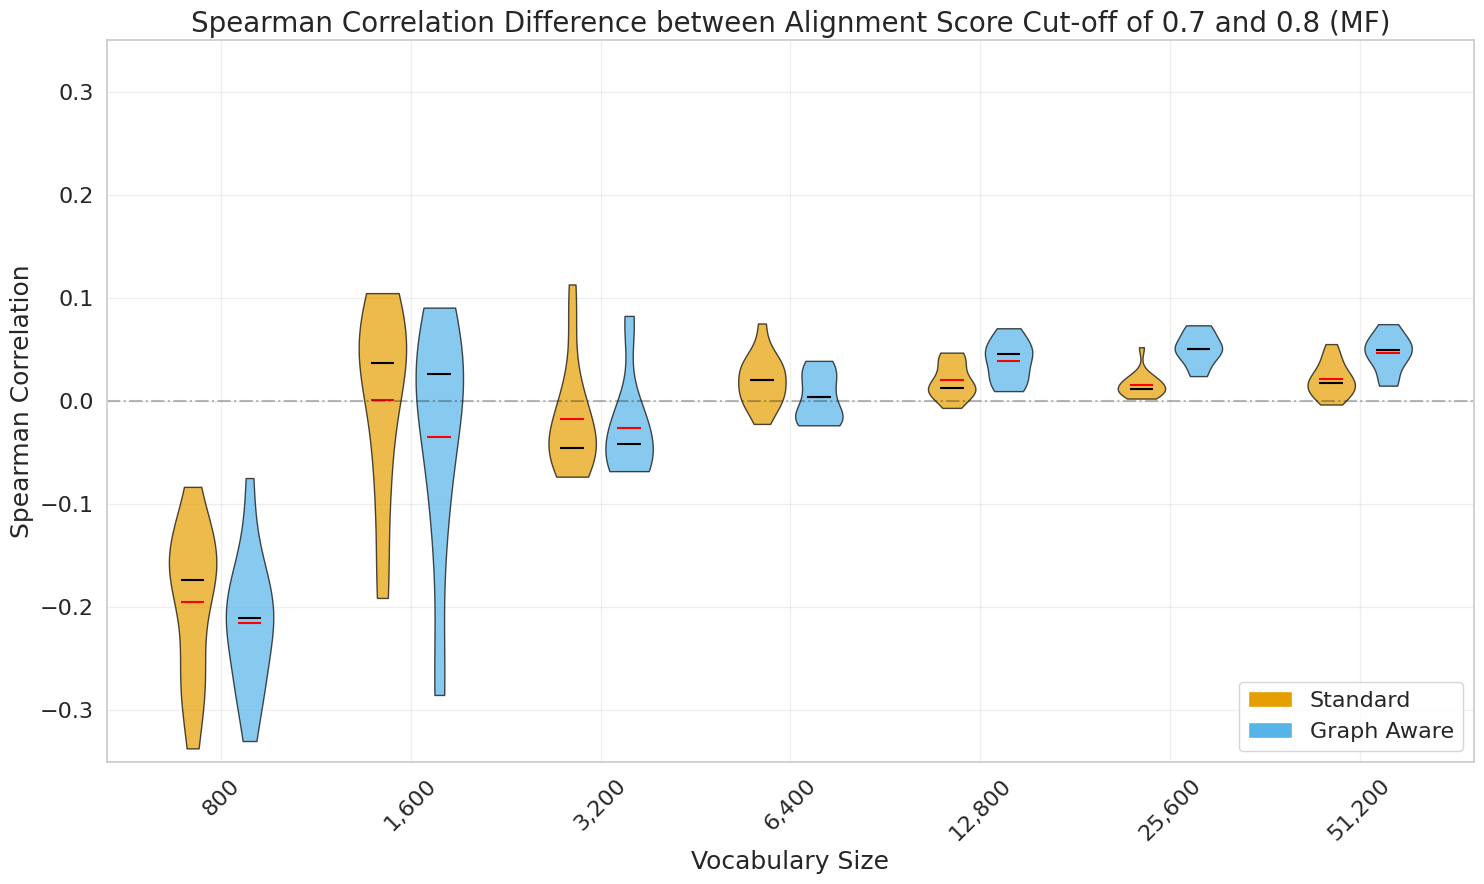

In [ ]:
# --- plot ---
fig, ax1 = plt.subplots(figsize=(15, 9))

colors = {
    "standard": "#E69F00",
    "graph_aware": "#56B4E9", 
} 

go_aspect = 'molecular_function' # ['molecular_function', 'biological_process', 'cellular_component']

metric = 'correlation_spearman_esm_unit'
results_df = results_df_raw[results_df_raw['top_n_strat'] == 'all'].groupby(['go_aspect', 'topic_model', 'tokenizer', 'vocab_size']).agg({'correlation_spearman_esm_unit': 'mean'}).reset_index()

thrs = ['0.7', '0.8']
# thrs = ['0.05', '0.005']

results_df = results_df[results_df['vocab_size'] != 0]

offset = 0.3  # horizontal offset for separation
vocab_sizes = sorted(results_df["vocab_size"].unique())
topic_models = ['standard', 'graph_aware']
topicmodesl2label = {
    "standard": "Standard",
    "graph_aware": "Graph Aware"
}

goaspect2labe = {
    "molecular_function": "Molecular Function",
    "biological_process": "Biological Process",
    "cellular_component": "Cellular Component"
}

for i, topic_model in enumerate(topic_models):
    df_filtered_1 = results_df[(results_df['tokenizer'].str.contains(thrs[0])) & ~(results_df['tokenizer'].str.contains('pam250')) & (results_df["go_aspect"] == go_aspect) & (results_df["topic_model"] == topic_model)]
    df_filtered_2 = results_df[(results_df['tokenizer'].str.contains(thrs[1])) & ~(results_df['tokenizer'].str.contains('pam250')) & (results_df["go_aspect"] == go_aspect) & (results_df["topic_model"] == topic_model)]
    for j, (((_, ), final_group1), ((_, ), final_group2)) in enumerate(zip(df_filtered_1.groupby(["vocab_size"]), df_filtered_2.groupby(["vocab_size"]))):
        # final_group = final_group[final_group['tokenizer'] != 'BPE']
        vals = final_group1.sort_values('tokenizer')[metric].values - final_group2.sort_values('tokenizer')[metric].values

        # plot violin, shifted for visibility
        parts = ax1.violinplot(
            vals,
            # positions=[i],  # shift left/center/right
            positions=[j + (i - 0.5) * offset],
            widths=0.25,
            showmeans=True,
            showmedians=True,
            showextrema=False
        )
        # colorize
        for pc in parts['bodies']:
            pc.set_facecolor(colors[topic_model])
            pc.set_edgecolor("black")
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color("black")
        if 'cmeans' in parts:
            parts['cmeans'].set_color("red")

# --- labels, legend, cosmetics ---
ax1.set_xticks(range(len(vocab_sizes)))
ax1.set_xticklabels([f"{v:,}" for v in vocab_sizes], rotation=45, ha="center")
ax1.tick_params(axis='both', labelsize=16)
ax1.set_xlabel("Vocabulary Size", fontsize=18)
ax1.set_ylabel("Spearman Correlation", fontsize=18)
ylim = 0.35
ax1.set_ylim(bottom=-ylim, top=ylim)
# ax1.set_title(f"Spearman Correlation Difference between Alignment Score Cut-off of {thrs[0]} and {thrs[1]} ({goaspect2labe[go_aspect]})", fontsize=20)
ax1.set_title(f"Spearman Correlation Difference between Alignment Score Cut-off of {thrs[0]} and {thrs[1]} (MF)", fontsize=20)
ax1.grid(True, alpha=0.3)

ax1.axhline(y=0, color='k', linestyle='-.', linewidth=1.5, alpha=0.3)

# custom legend
legend_handles = [Patch(facecolor=colors[m], label=topicmodesl2label[m]) for m in topic_models]
ax1.legend(handles=legend_handles, loc='lower right', fontsize=16)

    
plt.tight_layout()
plt.rcParams['figure.dpi'] = 300
plt.savefig("figures/go_sim_thrs_mf_78.eps", bbox_inches='tight')
plt.savefig("figures/go_sim_thrs_mf_78.png", bbox_inches='tight')
plt.show()